In [52]:
##Ejemplo de scorecard 
##Elaborado Dic-2022

#=============================
#========Importar lo necesario
#importar librerias
import scorecardpy as sc
import pandas as pd
import numpy as np
import warnings
import re
import matplotlib.pyplot as plt

from tabulate import tabulate
from math import * 
from datetime import datetime, timedelta,date
from scipy import stats
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [9, 5]

In [53]:
#importar datos
dat = sc.germancredit()

In [54]:
# filtrar datos de un total de 20 variables 
# nos quedamos con 13 variables
dt_s = sc.var_filter(dat, y="creditability")

#por default el train-test es 70-30
train, test = sc.split_df(dt=dt_s,y='creditability').values()

[INFO] filtering variables ...


In [55]:
#genera una agrupación óptima para 
#números, factores y categóricos, esto es para cada una de las 13 variables
bins = sc.woebin(dt=dt_s, y="creditability")

#graficar el resultado de bins
#sc.woebin_plot(bins)

[INFO] creating woe binning ...


In [56]:
# Aplicamos los cortes establecidos a train y test
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)

#separamos la variable independiente "y"
y_train = train_woe.loc[:,'creditability']
X_train = train_woe.loc[:,train_woe.columns != 'creditability']
y_test = test_woe.loc[:,'creditability']
X_test = test_woe.loc[:,train_woe.columns != 'creditability']

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [57]:
##entrenamos una regresion logistica utilizando sklearn
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)
# llamar betas y b0 del ajuste de regresión
## lr.coef_
## lr.intercept_

LogisticRegression(C=0.9, n_jobs=-1, penalty='l1', solver='saga')

In [58]:
# predecir la probabilidad
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

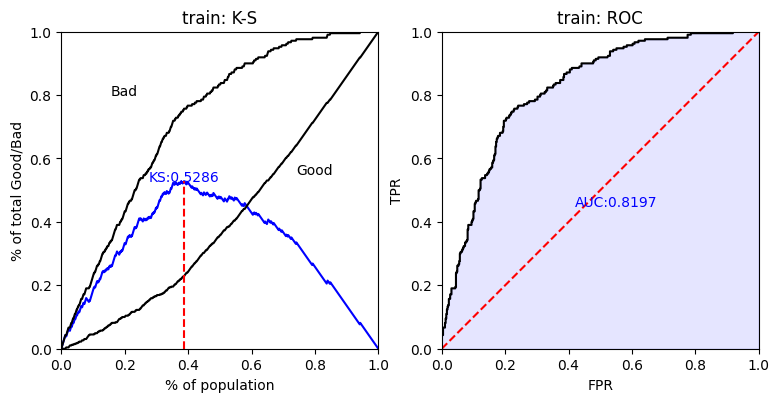

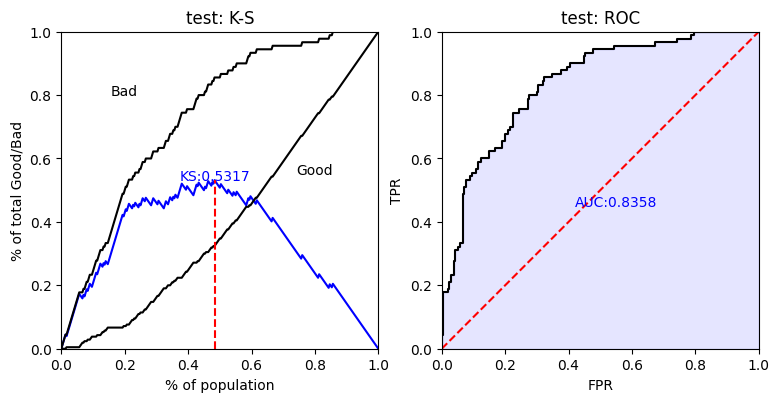

In [59]:
##evaluar las funciones acumuladas de kolmogorov smirnov
# performance ks & roc ------
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

In [60]:
# crear el score-card para ello utilizamos: 
# woe, betas ajustados e indicamos los atributos
card = sc.scorecard(bins, lr, X_train.columns)

In [61]:
##visualizar el scorecard, el nucleo del modelo
for i in card.keys():
    print(tabulate(pd.DataFrame(card[i]), headers='keys', tablefmt='psql'))

+----+------------+-------+----------+
|    | variable   |   bin |   points |
|----+------------+-------+----------|
|  0 | basepoints |   nan |      447 |
+----+------------+-------+----------+
+----+-------------------+-------------+----------+
|    | variable          | bin         |   points |
|----+-------------------+-------------+----------|
|  0 | duration_in_month | [-inf,8.0)  |       52 |
|  1 | duration_in_month | [8.0,16.0)  |       14 |
|  2 | duration_in_month | [16.0,34.0) |       -4 |
|  3 | duration_in_month | [34.0,44.0) |      -21 |
|  4 | duration_in_month | [44.0,inf)  |      -45 |
+----+-------------------+-------------+----------+
+----+-------------------------+---------------+----------+
|    | variable                | bin           |   points |
|----+-------------------------+---------------+----------|
|  5 | other_installment_plans | bank%,%stores |      -24 |
|  6 | other_installment_plans | none          |        6 |
+----+-------------------------+-----

In [62]:
#obtenemos el puntaje final (score) para la muestra de entrenamiento y prueba
train_score = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)

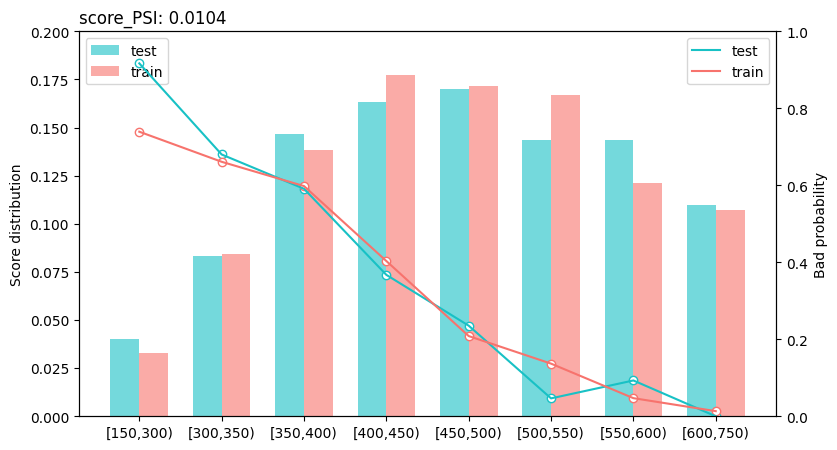

{'psi':   variable       PSI
 0    score  0.010375,
 'pic': {'score': <Figure size 900x500 with 2 Axes>}}

In [63]:
# calculamos el índice de estabilidad poblacional (PSI), esto es; 
# analizar la distribución de la puntuación crediticia 
#fig = plt.gcf()
#fig.set_size_inches(28.5, 10.5)

sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)
#plt.show()